<a href="https://colab.research.google.com/github/Al3pr6/Programming-Project/blob/release-2.0/Proyecto_Taller_II_Etapa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


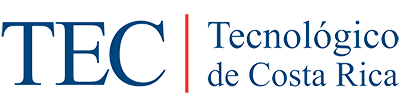
# **Instituto Tecnológico de Costa Rica | TEC**
# **Carrera de Ingeniería en Computación**
# **Proyecto Programado** *(Fase II – Entrevistador asistido por IA)* 
# **Hecho por:**
# *Maikol Flores y Alexander Ubeda*
# **Dr. Abel Méndez Porras**
# amendez@itcr.ac.cr
# **Porcentaje: 20%**
# **I Semestre de 2023**

# Entrevistador asistido por IA



El reconocimiento facial y la detección de emociones son tecnologías que se han vuelto cada vez más populares en los últimos años. Estas tecnologías utilizan algoritmos de inteligencia artificial para analizar imágenes y detectar patrones faciales que permiten identificar a las personas y sus emociones.
En cuanto a las oportunidades, el reconocimiento facial puede tener aplicaciones en la seguridad, el marketing y la atención al cliente. Por ejemplo, en la seguridad se pueden utilizar sistemas de reconocimiento facial para identificar a personas en lugares públicos o para controlar el acceso a edificios y sistemas de seguridad. En el marketing, se pueden utilizar para personalizar la publicidad en función de la edad, el género y otros datos demográficos. Y en la atención al cliente, se pueden utilizar para detectar la satisfacción del cliente en tiempo real y responder adecuadamente.

En esta primera etapa del proyecto del curso de Taller de Programación estaremos utilizando los resultados de consultas a modelos de Deep Learning para aplicar los conocimientos adquiridos en clase. 

## Objetivo
Desarrollar una aplicación de complejidad baja que permita poner en práctica los conocimientos adquiridos en los cursos de Introducción a la Programación y Taller de Programación.

## Objetivos Específicos
*  Identificar los requerimientos para resolver un problema específico desde la perspectiva de resolución de problemas, técnicas con listas, diccionarios, clases, objetos y archivos.
*  Diseñar una aplicación para un problema específico desde la perspectiva de resolución de problemas, técnicas con listas, diccionarios, clases, objetos y archivos.
*  Desarrollar una aplicación para un problema específico desde la perspectiva de resolución de problemas, técnicas con listas, diccionarios, clases, objetos y archivos.

# <font color='Green'>Configuración previa:</font>

### Cargar Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Leer cámara
Tomado de https://colab.research.google.com/drive/1QnC7lV7oVFk5OZCm75fqbLAfD9qBy9bw?usp=sharing#scrollTo=ilLkpcKanPRb



### Importar dependencies

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import pickle
import os
import shutil
import gdown

### Convertir el objeto JavaScript un objeto OpenCV image

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

### Crear nuestro live video stream

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

### Iniciar streaming video

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageFont

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from keras.models import model_from_json

### Cargar modelos de Deep Learning entrenados

*   Para detectar los rostros se utiliza el modelo de Face Haar Cascade.
*   Para detectar las emociones se utiliza el modelo de VGG.
*   También se utiliza un algoritmo adicional para pasar la información del algortimo de VGG a un formato JSON.

Estos modelos y algoritmos están disponibles en el siguiente enlace [Descargar modelos y algoritmos](https://drive.google.com/drive/folders/1KctA_s25bqqMOUlQuy0lwTm0HkBGVycF?usp=sharing). Usted los debe colocar en su Google Drive y modificar la ruta de acceso. 



In [ ]:
#Cargar modelos de Deep Learning entrenados
face_haar_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/Intro/Proyecto/haarcascade_frontalface_alt.xml') 
model = model_from_json(open("/content/drive/MyDrive/Intro/Proyecto/model.json", "r").read()) 
model.load_weights('/content/drive/MyDrive/Intro/Proyecto/model.h5')

Crear interfaz
https://www.youtube.com/watch?v=oIVmV41uyK8


## Cargar Archivos | <font color='green'>Ejecutar</font>

Estos son los archivos donde estarán los datos de las entrevistas, esto se puede editar en la seccion de Administrador, en la ultima sección de este Notebook

In [ ]:
# Archivo Evaluador
archivo_drive = '/content/drive/MyDrive/Intro/Proyecto/Archivo_Entrevistador'
destino_colab = '/content/Archivo_Entrevistador'
shutil.copyfile(archivo_drive, destino_colab)

# Archivo Evaluador
archivo_drive = '/content/drive/MyDrive/Intro/Proyecto/Archivo_Evaluador'
destino_colab = '/content/Archivo_Evaluador'
shutil.copyfile(archivo_drive, destino_colab)

# Archivo Entrevistado
archivo_drive = '/content/drive/MyDrive/Intro/Proyecto/Archivo_Entrevistado'
destino_colab = '/content/Archivo_Entrevistado'
shutil.copyfile(archivo_drive, destino_colab)

'/content/Archivo_Entrevistado'

#Perfiles del Entrevistador Personal

El entrevistador personal es una herramienta para recolectar información de personas que están aplicando a un puesto. En la aplicación existen tres perfiles el entrevistador, el entrevistado y el evaluador. La información de estos perfiles debe ser almacenada en clases y usando herencia. Debe existir una clase "padre" que tiene propiedades y métodos que comparten todos los perfiles. Para cada perfil debe existir una clase subordinada que hereda las propiedades de la clase "padre", además, tiene sus propias propiedades y métodos.

## Clase Principal

In [ ]:
class Personas():
  """
  This class is the main class, where the classes that appear after it will inherit.
  """
  def __init__(self, name, ide, date_of_birth, nationality, phone_numbers, emails, direction):
        self.name = name
        self.ide = ide
        self.date_of_birth = date_of_birth
        self.nationality = nationality
        self.phone_numbers = phone_numbers
        self.emails = emails
        self.direction = direction
  

## Recolectar información del entrevistador


El entrevistador es la persona encargada de realizar las entrevistas. 

Información requerida del entrevistador (Toda la información requerida debe ser almacenada en la clase Entrevistador. Cada vez que se registra un entrevistador se debe crear una instancia de la clase Entrevistador para guardar toda la información del entrevistador). 
*   Identificación  
*   Nombre 
*   Fecha de nacimiento
*   Nacionalidad
*   Números de teléfono y celular (un diccionario)
*   Emails (una lista con uno o varios emails)
*   Dirección

Usted debe incluir al menos tres propiedades únicas al entrevistador.
Cada vez que se crea una instancia de Entrevistador, la instancia debe ser almacenada en un archivo binario llamado Archivo_Entrevistador.

## Clase Entrevistador

In [ ]:
class Entrevistador(Personas):
    """
    This class is for interviewers, it will be in charge of processing the interviewers' information and saving it
    """ 
    def __init__(self, name, ide, date_of_birth, nationality, phone_numbers, emails, direction, carne, carrera, sede):
        Personas.__init__(self, name, ide, date_of_birth, nationality, phone_numbers, emails, direction)
        self.carne = carne
        self.carrera = carrera
        self.sede = sede

    def __str__(self):
        return f"Nombre: {self.name}, Identificacion: {self.ide}, Fecha de nacimiento: {self.date_of_birth}, Nacionalidad: {self.nationality}, Numero de telefono: {self.phone_numbers}, Correo: {self.correo}, Lugar de Residencia: {self.direction}, Número de Carnet: {self.carne}, Carrera: {self.carrera}, Sede: {self.sede}"

### Agregar Entrevistador

In [ ]:
def entrevistador():
  """
  This function will create a form for interviewers to register in the program
  """
  entrevistadores = []

  # It will read the Interviewer File and save it in a variable
  if os.path.getsize("Archivo_Entrevistador") > 0:
    with open("Archivo_Entrevistador", "rb") as archivo:
      entrevistadores = pickle.load(archivo)


    

 # This is the interviewer data form
  name = input("Nombre: ")
  ide = int(input("Identificación: "))
  date_of_birth = input("Fecha de Nacimiento: ")
  nationality = input("Ingrese el país de nacimiento: ")
  cantidad_numeros = int(input("Ingrese la cantidad de número de telefono que desea registrar: "))
  phone_numbers = {}
  for i in range(cantidad_numeros):
      numero = int(input("Número de telefono: "))
      phone_numbers.update({f"numero{i+1}": numero})
  cantidad_correos = int(input("Ingrese la cantidad de correos que desea registrar: "))
  emails = {}
  for i in range(cantidad_correos):
      correo = input("Dirección de Correo: ")
      emails.update({f"correo{i+1}": correo})
  direction = input("Dirección de Residencia: ")
  carne = input("Número de Carne: ")
  carrera = input("Carrera Universitaria: ")
  sede = input("Sede Universitaria: ")
  entrevistador = Entrevistador(name, ide, date_of_birth, nationality, phone_numbers, emails, direction, carne, carrera, sede)
  entrevistadores.append(entrevistador)
      

  #This will save the information to the file again
  with open("Archivo_Entrevistador", "wb") as f:
      pickle.dump(entrevistadores, f)
  archivo_vacio = False
  print("Se ha guardado la información correctamente")
      

entrevistador()

## Recolectar información del evaluador

El evaluador en la persona encargada de revisar la información obtenida de cada entrevista. 

Información requerida del evaluador (Toda la información requerida debe ser almacenada en la clase Evaluador. Cada vez que se registra un evaluador se debe crear una instancia de la clase Evaluador para guardar toda la información del evaluador). 
*   Identificación  
*   Nombre 
*   Fecha de nacimiento
*   Nacionalidad
*   Números de teléfono y celular (un diccionario)
*   Emails (una lista con uno o varios emails)
*   Dirección

Usted debe incluir al menos tres propiedades únicas al evaluador.
Cada vez que se crea una instancia de Evaluador, la instancia debe ser almacenada en un archivo binario llamado Archivo_Evaluador.

## Clase Evaluador

In [ ]:
class Evaluador(Personas):
    """
    This Class will be for the evaluator and will allow the evaluator to register
    """
    def __init__(self, ide, name, date_of_birth, nationality, phone_numbers, emails, direction, oficina, experiencia, id_evaluador, estado):
        Personas.__init__(self, ide, name, date_of_birth, nationality, phone_numbers, emails, direction)        
        self.oficina = oficina
        self.experiencia = experiencia
        self.id_evaluador = id_evaluador
        self.estado = estado

### Agregar Evaluador

In [ ]:
def evaluador():
  """
  This function will create a form for evaluators to register in the program
  """
  evaluadores = []
  # It will read the evaluator File and save it in a variable
  if os.path.getsize("Archivo_Evaluador") > 0:
    with open("Archivo_Evaluador", "rb") as archivo:
      evaluadores = pickle.load(archivo)



    

  # This is the evaluator data form
  name = input("Nombre: ")
  ide = int(input("Identificación: "))
  date_of_birth = input("Fecha de Nacimiento: ")
  nationality = input("Ingrese el país de nacimiento: ")
  cantidad_numeros = int(input("Ingrese la cantidad de número de telefono que desea registrar: "))
  phone_numbers = {}
  for i in range(cantidad_numeros):
      numero = int(input("Número de telefono: "))
      phone_numbers.update({f"numero{i+1}": numero})
  cantidad_correos = int(input("Ingrese la cantidad de correos que desea registrar: "))
  emails = {}
  for i in range(cantidad_correos):
      correo = input("Dirección de Correo: ")
      emails.update({f"correo{i+1}": correo})
  direction = input("Dirección de Residencia: ")
  oficina = input("Ingrese la oficina: ")
  experiencia = input("Nivel de Experiencia: ")
  id_evaluador = input("ID de evaluador: ")
  evaluador = Evaluador(name, ide, date_of_birth, nationality, phone_numbers, emails, direction, oficina, experiencia, id_evaluador)
  evaluadores.append(evaluador)


  #This will save the information to the file again
  with open("Archivo_Evaluador", "wb") as f:
      pickle.dump(evaluadores, f)
  archivo_vacio = False
  print("Se ha guardado la información correctamente")
      

evaluador()

## Recolectar información del entrevistado

El entrevistado es la persona que está interesada en el puesto de trabajo.

Información requerida al entrevistar una persona (Toda la información requerida debe ser almacenada en la clase Entrevistado. Cada vez que se registra un entrevistado se debe crear una instancia de la clase Entrevistado para guardar toda la información del entrevistado).
*   Identificación  
*   Nombre 
*   Fecha de nacimiento
*   Nacionalidad
*   Números de teléfono y celular (un diccionario)
*   Emails (una lista con uno o varios emails)
*   Dirección
*   Estado civil
*   Cantidad de hijos indicando el género, la fecha de nacimiento(un diccionario) 
*   Entrevistas (cada persona puede ser entrevistada cero o más veces). Las entrevistas se realizan en tiempo real utilizando una camára integrada a la computadora o externa (el profesor facilita el código para activar la camára, capturar el video y capturar los frames cada cierto tiempo). Se debe crear una lista con sublistas donde cada sublista tiene las imagenes capturas y las emociones reportadas durante la entrevista. Además, debe guardar coordenadas donde se encuentra el rostro en la imagen. Para cada entrevista, el entrevistado debe contar historias cortas sobre los siguientes 4 tópicos:


  >*   Una experiencia de sorpresa o asombro que ha tenido que vivir.
  >*   Una experiencia de tristeza que ha tenido que vivir.
  >*   Una experiencia de enojo o frustración que ha tenido que vivir.
  >*   Una experiencia de felicidad que ha tenido que vivir.

Un aspecto importante es que cada vez que se va a realizar una entrevista se debe indicar quién es el entrevistador.

Usted debe incluir al menos tres propiedades únicas al perfil de entrevistado. Cada vez que se crea una instancia de Entrevistado, la instancia debe ser almacenada en un archivo binario llamado Archivo_Entrevistado.

In [ ]:
class Entrevistado(Personas):
    def __init__(self, ide, name, date_of_birth, age, nationality, phone_numbers, emails, direction, civil_state, children, cont_child, entrevistador, image):
        Personas.__init__(self, ide, name, date_of_birth, nationality, phone_numbers, emails, direction)
        self.civil_state = civil_state
        self.children = children
        self.cont_child = cont_child
        self.entrevistador = entrevistador
        self.age = age
        self.image = image

In [ ]:
def persona_entrevistadora():
  persona_entrevistadora = []
  with open("Archivo_Entrevistador", "rb") as f:
    persona = pickle.load(f)
    for x in persona:
      nombre = x.name
      persona_entrevistadora.append(nombre)
  return persona_entrevistadora


def entrevistado():
  entrevistados = []

  if os.path.getsize("Archivo_Entrevistado") > 0:
    with open("Archivo_Entrevistado", "rb") as archivo:
      entrevistados = pickle.load(archivo)

  
  while True:
    stop = False 
    persona = persona_entrevistadora()
    print(persona)
    entrevistador = str(input("\nIngresa la persona entrevistadora: "))
    if entrevistador in persona:
        break
    else:
      print()
      print("El entrevistador no está en nuestra lista \nVerifica que esté en la lista o registra un entrevistador nuevo")


  name = input("Nombre: ")
  ide = int(input("Identificación: "))
  date_of_birth = input("Fecha de Nacimiento: ")
  age = input("Ingrese su cantidad de años: ")
  nationality = input("Ingrese el país de nacimiento: ")
  cantidad_numeros = int(input("Ingrese la cantidad de número de telefono que desea registrar: "))
  phone_numbers = {}
  for i in range(cantidad_numeros):
      numero = int(input("Número de telefono: "))
      phone_numbers.update({f"numero{i+1}": numero})
  cantidad_correos = int(input("Ingrese la cantidad de correos que desea registrar: "))
  emails = {}
  for i in range(cantidad_correos):
      correo = input("Dirección de Correo: ")
      emails.update({f"correo{i+1}": correo})
  direction = input("Dirección de Residencia: ")
  civil_state = input("Ingrese su estado civil: ")
  cont_child = int(input("Ingrese la cantidad de hijos: "))
  children = {}
  image = {"Image_info": ""}
  master_child = []
  for i in range(cont_child):
    child = {}
    genero = input("Ingrese el genero de su hijo: ")
    fecha_nacimiento = input("Ingrese la fecha de nacimiento de su hijo: ")
    child.update({"genero": genero})
    child.update({"nacimiento": fecha_nacimiento})
    master_child.append(child)
    children.update({f"hijo": master_child})
  
  entrevistado = Entrevistado(name, ide, date_of_birth, age, nationality, phone_numbers, emails, direction, civil_state, children, cont_child, entrevistador, image)
  entrevistados.append(entrevistado)

      #Guardar la informacion en el archivo


  with open("Archivo_Entrevistado", "wb") as f:
      pickle.dump(entrevistados, f)
  archivo_vacio = False
  print("\nSe ha guardado la información correctamente")
      

entrevistado()

### Recolectar información emociones
Este código se encarga de ejecutar la captura de video de la cámara, detectar los rostros en las imágenes y reconocer las emociones presentes en los rostros. Cuando se hace la entrevista es en este código donde usted de obtener la información para crear las listas con la información solicitada.

In [ ]:
def entrevista():
  """ 
  This function will add photo information, emotion, and coordinate to a list 
  """
  list_temp = []
  # Add information of photos and emotion to a "list_temp":
  list_temp.append(image_path)
  list_temp.append(emotion_prediction)
  # Create a list of the coordinates of the image:
  face = []
  face2 = faces_detected[0]
  c = 0
  while c <= 3:
    face3 = face2[c]
    face.append(face3)
    c += 1
  list_temp.append(face)
  # Send the every information of interview to a list "result":
  result.append(list_temp)

¿De quien es la entrevista? ['Jan Molina', 'Luis Mendez']
Escribe a continuación tu nombre: Luis Mendez


<IPython.core.display.Javascript object>

Rostro de Luis Mendez
Ubicación del rostro: [[228 200 158 158]]
1/1 [==============================] - 0s 77ms/step
Predicciones:  [[0.02591705 0.00104837 0.02416271 0.5443177  0.06367537 0.01075507
  0.33012366]]
3 [0.02591705 0.00104837 0.02416271 0.5443177  0.06367537 0.01075507
 0.33012366]
Predicciones:  {'angry': 0.025917053, 'disgust': 0.0010483686, 'fear': 0.024162706, 'happiness': 0.5443177, 'sadness': 0.063675374, 'surprise': 0.010755066, 'neutral': 0.33012366}
happyness


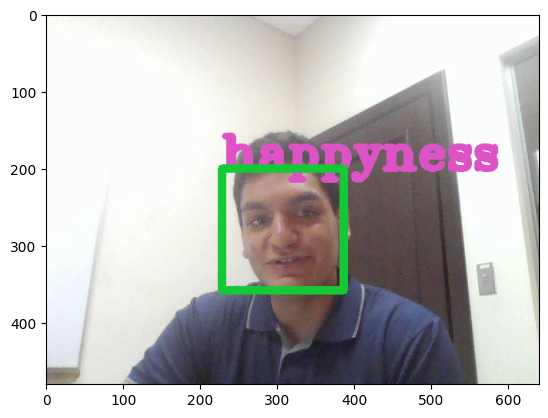

Rostro de Luis Mendez
Ubicación del rostro: [[238 201 156 156]]
1/1 [==============================] - 0s 62ms/step
Predicciones:  [[0.04524486 0.00113474 0.04165152 0.22715035 0.08875639 0.01523779
  0.5808244 ]]
6 [0.04524486 0.00113474 0.04165152 0.22715035 0.08875639 0.01523779
 0.5808244 ]
Predicciones:  {'angry': 0.04524486, 'disgust': 0.0011347396, 'fear': 0.041651517, 'happiness': 0.22715035, 'sadness': 0.08875639, 'surprise': 0.0152377905, 'neutral': 0.5808244}
neutral


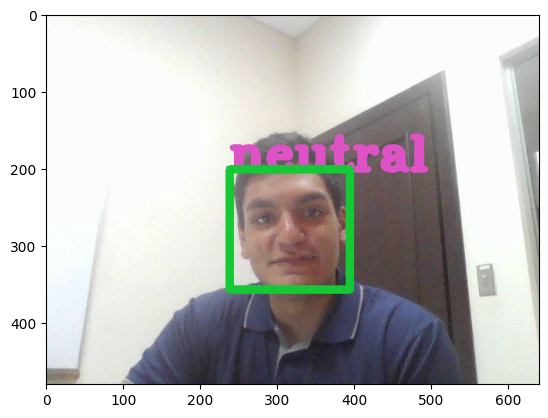

Rostro de Luis Mendez
Ubicación del rostro: [[265 197 168 168]]
1/1 [==============================] - 0s 102ms/step
Predicciones:  [[0.09479529 0.00456992 0.06539486 0.25858024 0.12721166 0.02244378
  0.42700416]]
6 [0.09479529 0.00456992 0.06539486 0.25858024 0.12721166 0.02244378
 0.42700416]
Predicciones:  {'angry': 0.094795294, 'disgust': 0.0045699193, 'fear': 0.065394856, 'happiness': 0.25858024, 'sadness': 0.12721166, 'surprise': 0.022443779, 'neutral': 0.42700416}
neutral


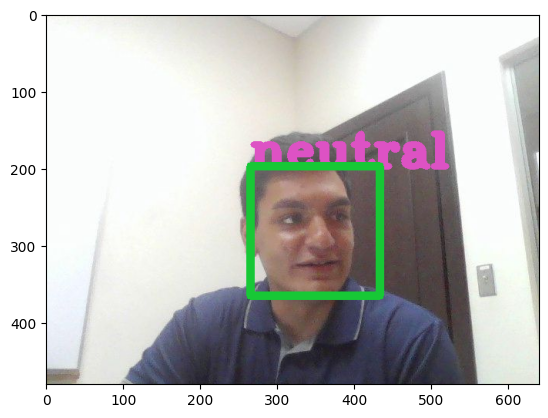

Rostro de Luis Mendez
Ubicación del rostro: [[240 202 152 152]]
1/1 [==============================] - 0s 59ms/step
Predicciones:  [[0.10947059 0.0045616  0.15321079 0.09943751 0.3291954  0.01645065
  0.2876735 ]]
4 [0.10947059 0.0045616  0.15321079 0.09943751 0.3291954  0.01645065
 0.2876735 ]
Predicciones:  {'angry': 0.10947059, 'disgust': 0.0045616007, 'fear': 0.15321079, 'happiness': 0.099437505, 'sadness': 0.3291954, 'surprise': 0.016450653, 'neutral': 0.2876735}
sadness


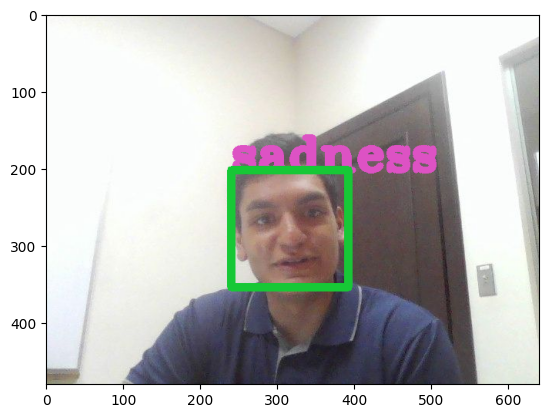

Rostro de Luis Mendez
Ubicación del rostro: [[200 193 147 147]]
1/1 [==============================] - 0s 56ms/step
Predicciones:  [[0.0506639  0.0021429  0.05433275 0.32206118 0.11655369 0.01904107
  0.43520457]]
6 [0.0506639  0.0021429  0.05433275 0.32206118 0.11655369 0.01904107
 0.43520457]
Predicciones:  {'angry': 0.0506639, 'disgust': 0.0021428985, 'fear': 0.05433275, 'happiness': 0.32206118, 'sadness': 0.11655369, 'surprise': 0.019041073, 'neutral': 0.43520457}
neutral


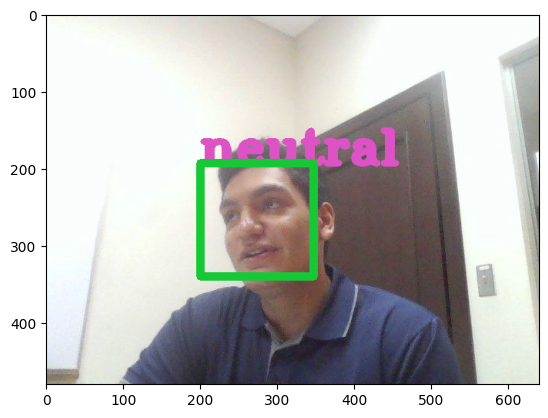

Rostro de Luis Mendez
Ubicación del rostro: [[232 193 168 168]]
1/1 [==============================] - 0s 60ms/step
Predicciones:  [[0.02303007 0.00156742 0.04254497 0.69322586 0.10820053 0.01015307
  0.12127808]]
3 [0.02303007 0.00156742 0.04254497 0.69322586 0.10820053 0.01015307
 0.12127808]
Predicciones:  {'angry': 0.023030067, 'disgust': 0.001567422, 'fear': 0.042544972, 'happiness': 0.69322586, 'sadness': 0.10820053, 'surprise': 0.010153073, 'neutral': 0.12127808}
happyness


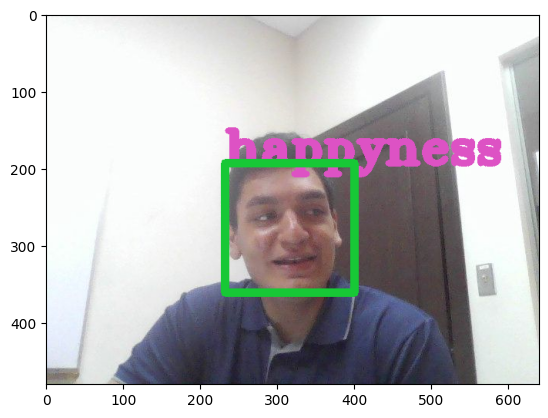

Rostro de Luis Mendez
Ubicación del rostro: [[199 201 160 160]]
1/1 [==============================] - 0s 59ms/step
Predicciones:  [[0.06434205 0.00334339 0.07496174 0.3204436  0.16838555 0.02106429
  0.34745938]]
6 [0.06434205 0.00334339 0.07496174 0.3204436  0.16838555 0.02106429
 0.34745938]
Predicciones:  {'angry': 0.06434205, 'disgust': 0.0033433933, 'fear': 0.074961744, 'happiness': 0.3204436, 'sadness': 0.16838555, 'surprise': 0.021064289, 'neutral': 0.34745938}
neutral


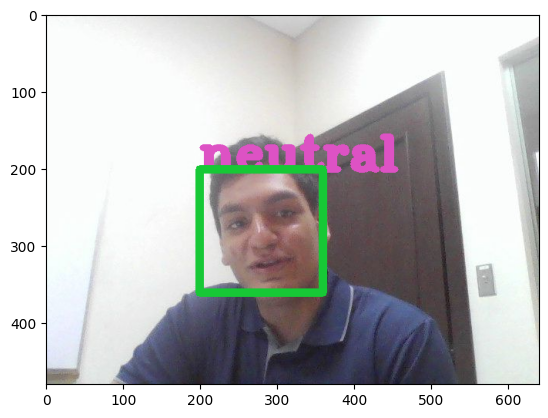

Rostro de Luis Mendez
Ubicación del rostro: ()


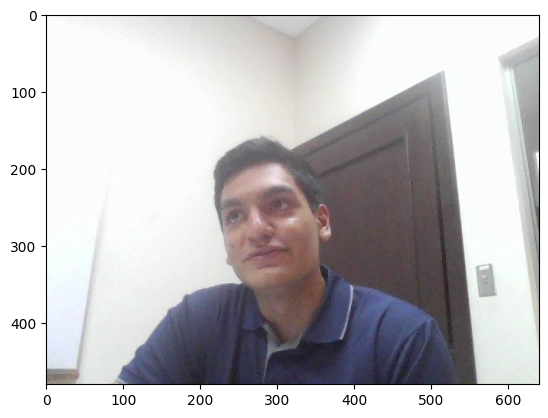

Rostro de Luis Mendez
Ubicación del rostro: [[195 192 156 156]]
1/1 [==============================] - 0s 59ms/step
Predicciones:  [[0.01846578 0.00101532 0.03323606 0.64951235 0.10590807 0.00876146
  0.18310101]]
3 [0.01846578 0.00101532 0.03323606 0.64951235 0.10590807 0.00876146
 0.18310101]
Predicciones:  {'angry': 0.018465776, 'disgust': 0.00101532, 'fear': 0.03323606, 'happiness': 0.64951235, 'sadness': 0.10590807, 'surprise': 0.008761462, 'neutral': 0.18310101}
happyness


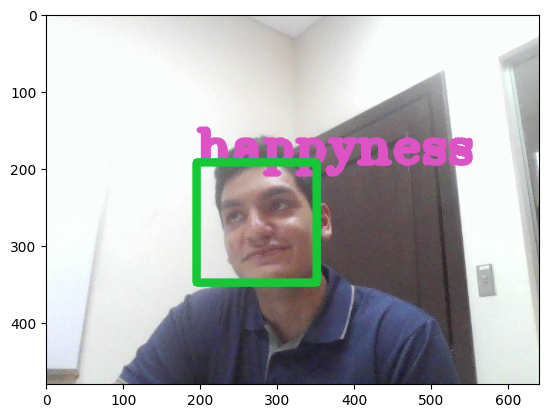

Rostro de Luis Mendez
Ubicación del rostro: [[222 201 162 162]]
1/1 [==============================] - 0s 56ms/step
Predicciones:  [[4.8270067e-03 9.3760609e-05 5.8525270e-03 8.0706936e-01 1.1168892e-02
  6.5021040e-03 1.6448642e-01]]
3 [4.8270067e-03 9.3760609e-05 5.8525270e-03 8.0706936e-01 1.1168892e-02
 6.5021040e-03 1.6448642e-01]
Predicciones:  {'angry': 0.0048270067, 'disgust': 9.376061e-05, 'fear': 0.005852527, 'happiness': 0.80706936, 'sadness': 0.011168892, 'surprise': 0.006502104, 'neutral': 0.16448642}
happyness


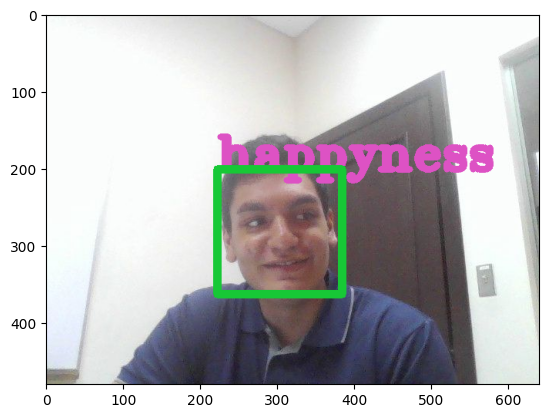

Rostro de Luis Mendez
Ubicación del rostro: [[293 200 153 153]]
1/1 [==============================] - 0s 57ms/step
Predicciones:  [[0.01802469 0.00070764 0.01363655 0.68187577 0.05490508 0.00436229
  0.22648805]]
3 [0.01802469 0.00070764 0.01363655 0.68187577 0.05490508 0.00436229
 0.22648805]
Predicciones:  {'angry': 0.018024692, 'disgust': 0.0007076352, 'fear': 0.013636548, 'happiness': 0.68187577, 'sadness': 0.054905083, 'surprise': 0.0043622903, 'neutral': 0.22648805}
happyness


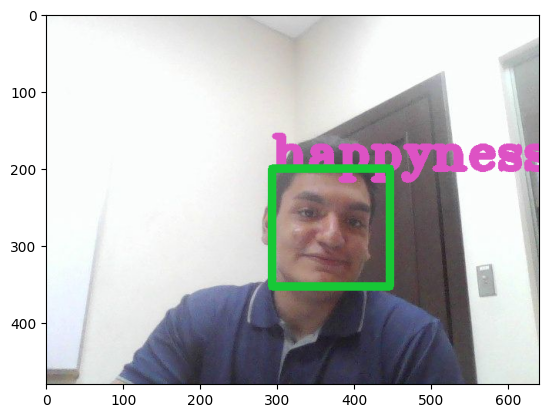

Rostro de Luis Mendez
Ubicación del rostro: [[267 198 169 169]]
1/1 [==============================] - 0s 115ms/step
Predicciones:  [[0.0706602  0.00533455 0.11650264 0.3212551  0.29049143 0.01614982
  0.17960636]]
3 [0.0706602  0.00533455 0.11650264 0.3212551  0.29049143 0.01614982
 0.17960636]
Predicciones:  {'angry': 0.070660196, 'disgust': 0.005334552, 'fear': 0.116502635, 'happiness': 0.3212551, 'sadness': 0.29049143, 'surprise': 0.016149823, 'neutral': 0.17960636}
happyness


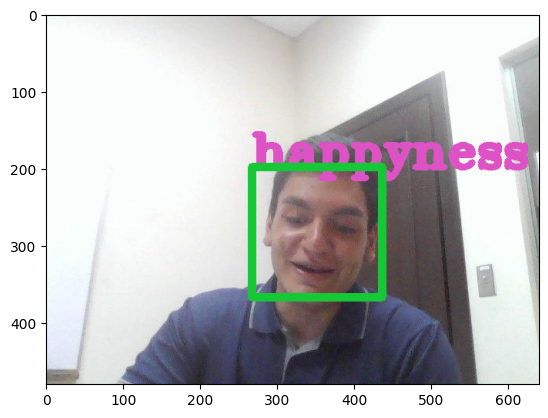

Rostro de Luis Mendez
Ubicación del rostro: [[224 187 162 162]]
1/1 [==============================] - 0s 59ms/step
Predicciones:  [[1.9338916e-03 4.1003666e-05 3.9164745e-03 9.5868480e-01 6.4488635e-03
  2.1144564e-03 2.6860543e-02]]
3 [1.9338916e-03 4.1003666e-05 3.9164745e-03 9.5868480e-01 6.4488635e-03
 2.1144564e-03 2.6860543e-02]
Predicciones:  {'angry': 0.0019338916, 'disgust': 4.1003666e-05, 'fear': 0.0039164745, 'happiness': 0.9586848, 'sadness': 0.0064488635, 'surprise': 0.0021144564, 'neutral': 0.026860543}
happyness


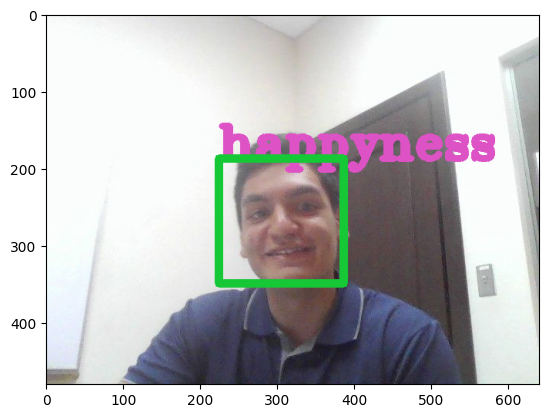

Rostro de Luis Mendez
Ubicación del rostro: ()


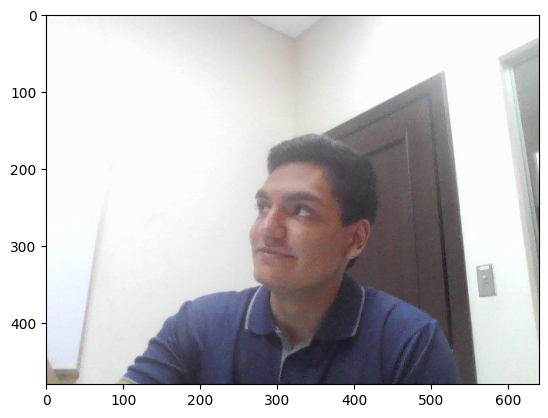

Rostro de Luis Mendez
Ubicación del rostro: [[258 210 137 137]]
1/1 [==============================] - 0s 57ms/step
Predicciones:  [[0.0303818  0.00082837 0.08914411 0.2256592  0.21558765 0.01806803
  0.42033082]]
6 [0.0303818  0.00082837 0.08914411 0.2256592  0.21558765 0.01806803
 0.42033082]
Predicciones:  {'angry': 0.030381802, 'disgust': 0.00082836865, 'fear': 0.08914411, 'happiness': 0.2256592, 'sadness': 0.21558765, 'surprise': 0.018068032, 'neutral': 0.42033082}
neutral


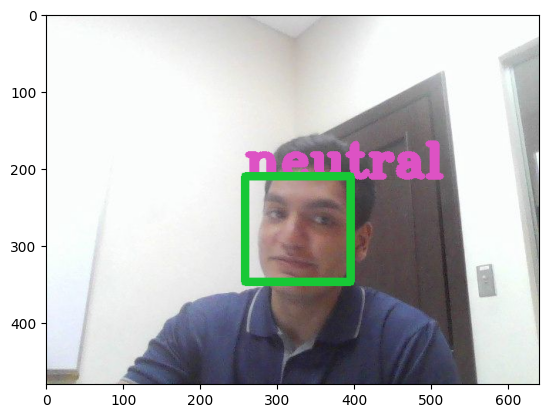

Rostro de Luis Mendez
Ubicación del rostro: [[280 204 168 168]]
1/1 [==============================] - 0s 145ms/step
Predicciones:  [[0.05778214 0.00200137 0.06084202 0.2072099  0.11423173 0.02374848
  0.53418434]]
6 [0.05778214 0.00200137 0.06084202 0.2072099  0.11423173 0.02374848
 0.53418434]
Predicciones:  {'angry': 0.05778214, 'disgust': 0.0020013696, 'fear': 0.06084202, 'happiness': 0.2072099, 'sadness': 0.11423173, 'surprise': 0.023748476, 'neutral': 0.53418434}
neutral


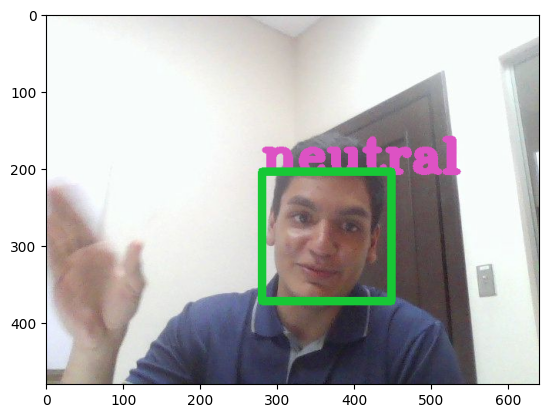

Rostro de Luis Mendez
Ubicación del rostro: [[243 191 169 169]]
1/1 [==============================] - 0s 63ms/step
Predicciones:  [[0.09496999 0.00400773 0.08362308 0.20403323 0.17459594 0.01978598
  0.4189841 ]]
6 [0.09496999 0.00400773 0.08362308 0.20403323 0.17459594 0.01978598
 0.4189841 ]
Predicciones:  {'angry': 0.09496999, 'disgust': 0.0040077255, 'fear': 0.08362308, 'happiness': 0.20403323, 'sadness': 0.17459594, 'surprise': 0.019785982, 'neutral': 0.4189841}
neutral


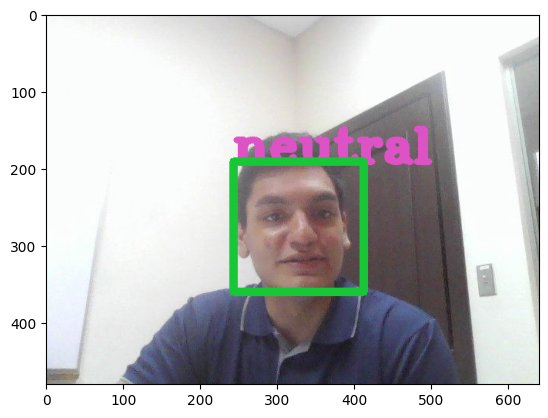

Rostro de Luis Mendez
Ubicación del rostro: ()


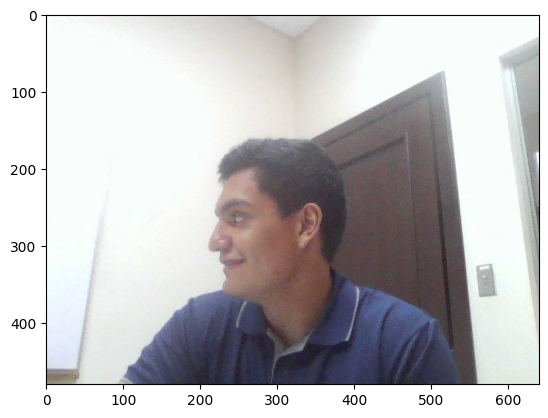

Rostro de Luis Mendez
Ubicación del rostro: [[244 183 158 158]]
1/1 [==============================] - 0s 58ms/step
Predicciones:  [[1.04484642e-02 3.58963414e-04 1.18274335e-02 8.09719265e-01
  3.18702459e-02 5.15552936e-03 1.30620167e-01]]
3 [1.04484642e-02 3.58963414e-04 1.18274335e-02 8.09719265e-01
 3.18702459e-02 5.15552936e-03 1.30620167e-01]
Predicciones:  {'angry': 0.010448464, 'disgust': 0.0003589634, 'fear': 0.0118274335, 'happiness': 0.80971926, 'sadness': 0.031870246, 'surprise': 0.0051555294, 'neutral': 0.13062017}
happyness


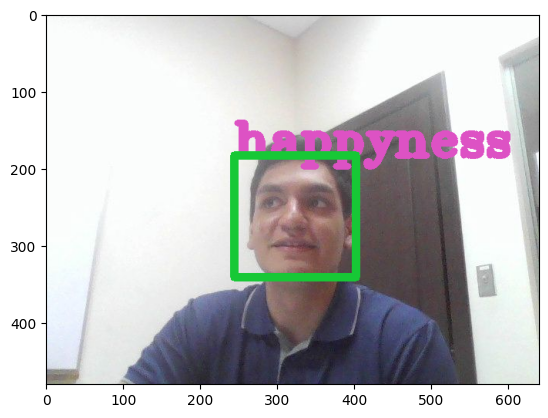

Rostro de Luis Mendez
Ubicación del rostro: ()


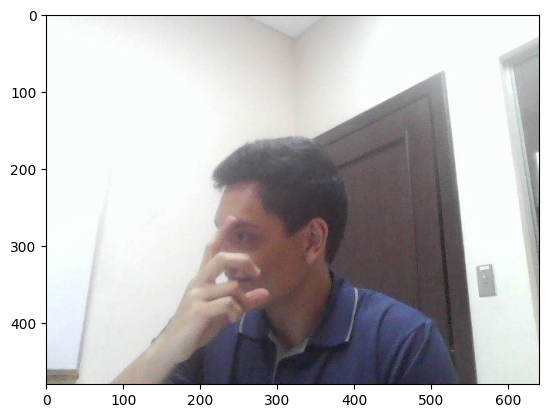

Rostro de Luis Mendez
Ubicación del rostro: [[236 192 160 160]]
1/1 [==============================] - 0s 59ms/step
Predicciones:  [[0.10281296 0.00611963 0.12244254 0.198207   0.19092561 0.04106376
  0.33842853]]
6 [0.10281296 0.00611963 0.12244254 0.198207   0.19092561 0.04106376
 0.33842853]
Predicciones:  {'angry': 0.10281296, 'disgust': 0.006119628, 'fear': 0.122442536, 'happiness': 0.198207, 'sadness': 0.19092561, 'surprise': 0.041063763, 'neutral': 0.33842853}
neutral


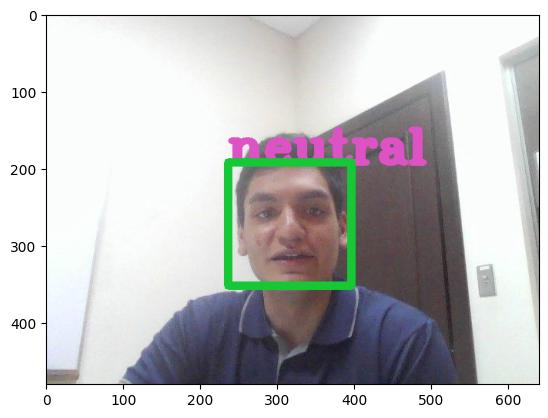

Rostro de Luis Mendez
Ubicación del rostro: [[255 198 159 159]]
1/1 [==============================] - 0s 57ms/step
Predicciones:  [[0.08390384 0.00223176 0.0518877  0.13557832 0.09606687 0.02596261
  0.60436887]]
6 [0.08390384 0.00223176 0.0518877  0.13557832 0.09606687 0.02596261
 0.60436887]
Predicciones:  {'angry': 0.08390384, 'disgust': 0.002231761, 'fear': 0.051887702, 'happiness': 0.13557832, 'sadness': 0.09606687, 'surprise': 0.025962612, 'neutral': 0.60436887}
neutral


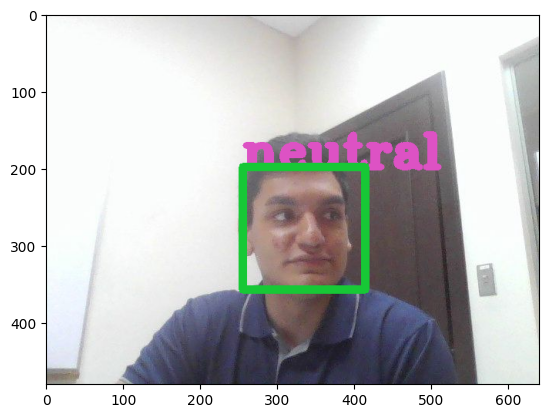

Rostro de Luis Mendez
Ubicación del rostro: [[249 199 166 166]]
1/1 [==============================] - 0s 71ms/step
Predicciones:  [[0.1397658  0.00293965 0.07445737 0.04509927 0.1536763  0.01885236
  0.5652092 ]]
6 [0.1397658  0.00293965 0.07445737 0.04509927 0.1536763  0.01885236
 0.5652092 ]
Predicciones:  {'angry': 0.1397658, 'disgust': 0.002939646, 'fear': 0.07445737, 'happiness': 0.04509927, 'sadness': 0.1536763, 'surprise': 0.018852357, 'neutral': 0.5652092}
neutral


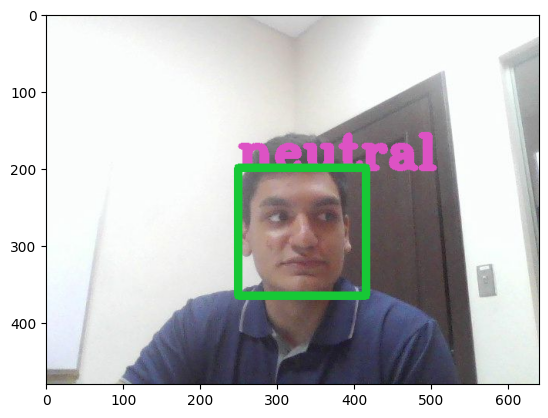

Rostro de Luis Mendez
Ubicación del rostro: [[230 186 156 156]]
1/1 [==============================] - 0s 130ms/step
Predicciones:  [[0.06685098 0.00123998 0.21481335 0.0173884  0.39221475 0.01191763
  0.29557496]]
4 [0.06685098 0.00123998 0.21481335 0.0173884  0.39221475 0.01191763
 0.29557496]
Predicciones:  {'angry': 0.06685098, 'disgust': 0.001239981, 'fear': 0.21481335, 'happiness': 0.017388396, 'sadness': 0.39221475, 'surprise': 0.011917631, 'neutral': 0.29557496}
sadness


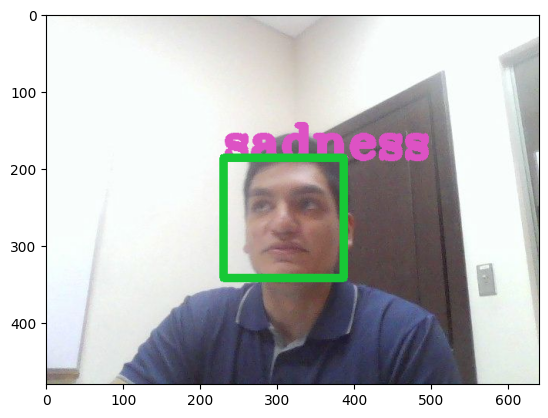

Rostro de Luis Mendez
Ubicación del rostro: [[298 200 166 166]]
1/1 [==============================] - 0s 59ms/step
Predicciones:  [[0.10596304 0.00272145 0.0728296  0.09182319 0.15819167 0.0159881
  0.5524829 ]]
6 [0.10596304 0.00272145 0.0728296  0.09182319 0.15819167 0.0159881
 0.5524829 ]
Predicciones:  {'angry': 0.105963044, 'disgust': 0.0027214512, 'fear': 0.072829604, 'happiness': 0.09182319, 'sadness': 0.15819167, 'surprise': 0.015988104, 'neutral': 0.5524829}
neutral


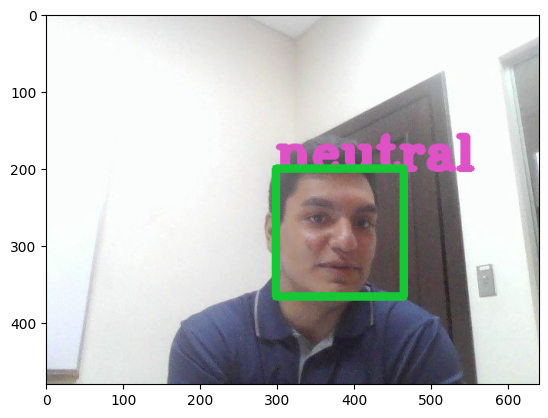

Rostro de Luis Mendez
Ubicación del rostro: [[317 190 172 172]]
1/1 [==============================] - 0s 57ms/step
Predicciones:  [[0.08940006 0.00203354 0.12419618 0.04945027 0.2717192  0.01210031
  0.4511005 ]]
6 [0.08940006 0.00203354 0.12419618 0.04945027 0.2717192  0.01210031
 0.4511005 ]
Predicciones:  {'angry': 0.08940006, 'disgust': 0.0020335417, 'fear': 0.12419618, 'happiness': 0.049450267, 'sadness': 0.2717192, 'surprise': 0.012100314, 'neutral': 0.4511005}
neutral


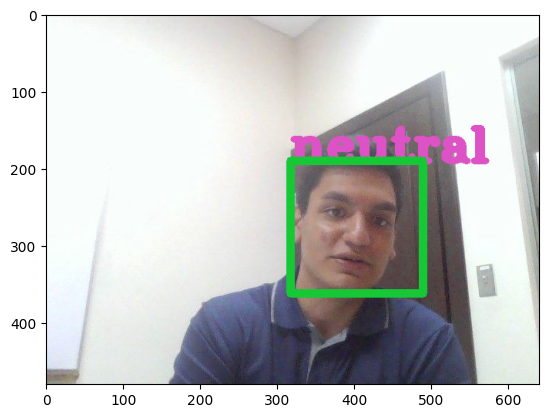

Rostro de Luis Mendez
Ubicación del rostro: [[240 200 158 158]]
1/1 [==============================] - 0s 58ms/step
Predicciones:  [[0.07274035 0.00065737 0.10294538 0.00822831 0.17366207 0.01734461
  0.6244219 ]]
6 [0.07274035 0.00065737 0.10294538 0.00822831 0.17366207 0.01734461
 0.6244219 ]
Predicciones:  {'angry': 0.072740346, 'disgust': 0.0006573658, 'fear': 0.10294538, 'happiness': 0.00822831, 'sadness': 0.17366207, 'surprise': 0.017344609, 'neutral': 0.6244219}
neutral


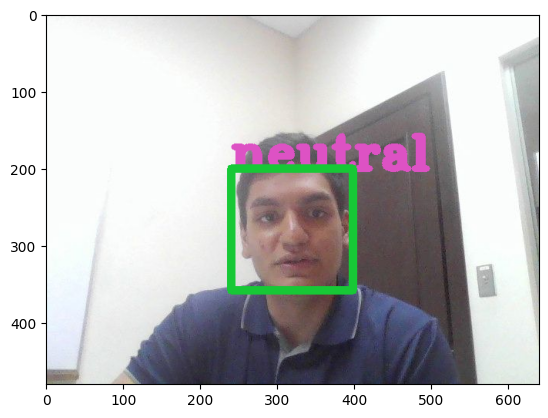

Rostro de Luis Mendez
Ubicación del rostro: [[239 184 162 162]]
1/1 [==============================] - 0s 105ms/step
Predicciones:  [[0.0740905  0.00124775 0.18047519 0.01466392 0.27690727 0.0183506
  0.4342648 ]]
6 [0.0740905  0.00124775 0.18047519 0.01466392 0.27690727 0.0183506
 0.4342648 ]
Predicciones:  {'angry': 0.0740905, 'disgust': 0.0012477494, 'fear': 0.18047519, 'happiness': 0.0146639235, 'sadness': 0.27690727, 'surprise': 0.018350605, 'neutral': 0.4342648}
neutral


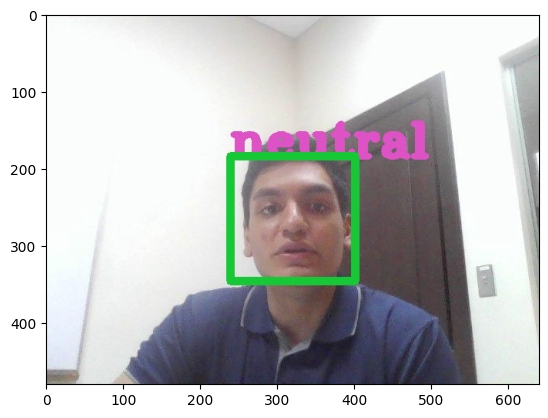

Rostro de Luis Mendez
Ubicación del rostro: [[280 199 164 164]]
1/1 [==============================] - 0s 61ms/step
Predicciones:  [[0.07865214 0.00170268 0.06605912 0.08050542 0.13539733 0.01847001
  0.61921334]]
6 [0.07865214 0.00170268 0.06605912 0.08050542 0.13539733 0.01847001
 0.61921334]
Predicciones:  {'angry': 0.078652136, 'disgust': 0.00170268, 'fear': 0.06605912, 'happiness': 0.080505416, 'sadness': 0.13539733, 'surprise': 0.018470012, 'neutral': 0.61921334}
neutral


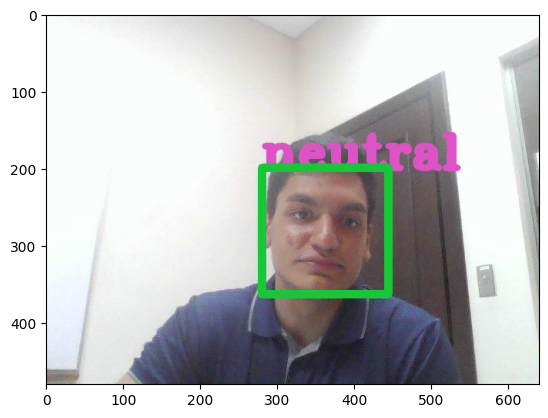

Rostro de Luis Mendez
Ubicación del rostro: [[254 193 164 164]]
1/1 [==============================] - 0s 66ms/step
Predicciones:  [[0.09803712 0.00218108 0.10226879 0.06677018 0.3058323  0.00618455
  0.41872597]]
6 [0.09803712 0.00218108 0.10226879 0.06677018 0.3058323  0.00618455
 0.41872597]
Predicciones:  {'angry': 0.09803712, 'disgust': 0.0021810755, 'fear': 0.102268785, 'happiness': 0.06677018, 'sadness': 0.3058323, 'surprise': 0.006184554, 'neutral': 0.41872597}
neutral


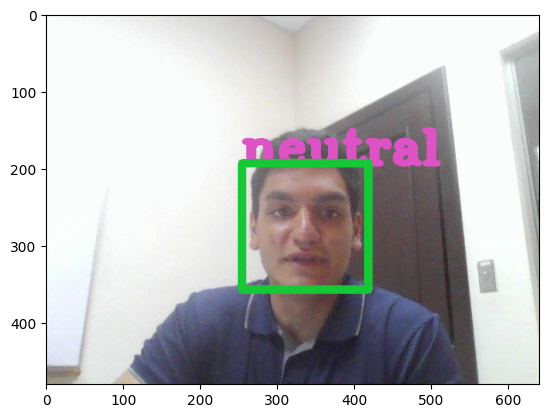

{'Image_info': [['/content/drive/MyDrive/Intro/Proyecto/Imagenes II/Luis Mendez5.jpg', 'happyness', [228, 200, 158, 158]], ['/content/drive/MyDrive/Intro/Proyecto/Imagenes II/Luis Mendez10.jpg', 'neutral', [238, 201, 156, 156]], ['/content/drive/MyDrive/Intro/Proyecto/Imagenes II/Luis Mendez15.jpg', 'neutral', [265, 197, 168, 168]], ['/content/drive/MyDrive/Intro/Proyecto/Imagenes II/Luis Mendez20.jpg', 'sadness', [240, 202, 152, 152]], ['/content/drive/MyDrive/Intro/Proyecto/Imagenes II/Luis Mendez25.jpg', 'neutral', [200, 193, 147, 147]], ['/content/drive/MyDrive/Intro/Proyecto/Imagenes II/Luis Mendez30.jpg', 'happyness', [232, 193, 168, 168]], ['/content/drive/MyDrive/Intro/Proyecto/Imagenes II/Luis Mendez35.jpg', 'neutral', [199, 201, 160, 160]], ['/content/drive/MyDrive/Intro/Proyecto/Imagenes II/Luis Mendez45.jpg', 'happyness', [195, 192, 156, 156]], ['/content/drive/MyDrive/Intro/Proyecto/Imagenes II/Luis Mendez50.jpg', 'happyness', [222, 201, 162, 162]], ['/content/drive/MyDriv

In [ ]:
from tensorflow.python.ops.math_ops import sign
lista_personas = []
result = []
with open("Archivo_Entrevistado", "rb") as f:
    persona = pickle.load(f)
    for person in persona:
      nombre = person.name
      lista_personas.append(nombre)


print("¿De quien es la entrevista?", lista_personas )
nombre = str(input("Escribe a continuación tu nombre: "))
while nombre not in lista_personas:
  print("Error,", nombre, "no está en la lista")
  print("¿De quien es la entrevista?", lista_personas )
  nombre = str(input("Escribe a continuación tu nombre: "))


for x in persona:
  entrevistado = x.name
  if entrevistado == nombre:
    image = x.image



      

# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
j = 5
while True:
  js_reply = video_frame(label_html, bbox)
  if not js_reply:
    break

  # convert JS response to OpenCV Image
  img = js_to_image(js_reply["img"])
  img_copy = img

  # create transparent overlay for bounding box
  bbox_array = np.zeros([480,640,4], dtype=np.uint8)


  if count == j: #El tiempo para capturar el frame y procesarlo
    #Este sería el path de la imagen guardada
    image_path ='/content/drive/MyDrive/Intro/Proyecto/Imagenes II/' + nombre + str(j) +  '.jpg'
    #se guarda el fotograma con el "nombre" más el número del contador i
    cv2.imwrite(image_path , img)
    #Imprime el nombre del usuario
    print("Rostro de", nombre) 
    #Detectar los rostros usando Face Haar Cascade
    gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #En faces_deteted se encuentran los rotros detectados
    faces_detected = face_haar_cascade.detectMultiScale(gray_image,1.32,5)
    #Imprimir ubicación de los rostros en la imagen
    print("Ubicación del rostro:", faces_detected)
    im2Display = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imTemp = im2Display.copy()

    #Hacer un rectángulo en cada rostro detectado en la imagen
    for (x,y,w,h) in faces_detected:
        cv2.rectangle(img,(x,y), (x+w,y+h), (255,0,0), thickness=7)

        roi_gray=gray_image[y:y+w,x:x+h]
        roi_gray=cv2.resize(roi_gray,(48,48))

        #Processes the image and adjust it to pass it to the model
        image_pixels = tf.keras.preprocessing.image.img_to_array(roi_gray)
       
        image_pixels = np.expand_dims(image_pixels, axis = 0)
        image_pixels /= 255

        #Obtener las emociones para cada rostro detectado en la imagen
        #Get the prediction of the model
        predictions = model.predict(image_pixels)
        #Mostrar todas las emociones detectadas
        print("Predicciones: ", predictions)
        #Mostrar la emoción más significativa (con el valor más alto)
        max_index = np.argmax(predictions[0])
        print(max_index, predictions[0])
        #El orden en que vienen las emociones
        emotion_detection = ('angry', 'disgust', 'fear', 'happyness', 'sadness', 'surprise', 'neutral')

        emotion_prediction = emotion_detection[max_index]
        #Crear un diccionario para almacenar la emoción y el valor para la emoción
        frame_dic = dict(
            angry = predictions[0][0],
            disgust = predictions[0][1],
            fear = predictions[0][2],            
            happiness = predictions[0][3],
            sadness = predictions[0][4],
            surprise = predictions[0][5],
            neutral = predictions[0][6]) 
        print("Predicciones: ", frame_dic)
        print( emotion_prediction )
        entrevista()
        
        #Mostrar en la imagen un texto de la emoción más significativa
        ubicacion = (x,y)
        font = cv2.FONT_HERSHEY_TRIPLEX
        tamañoLetra = 2
        colorLetra = (221,82,196)
        grosorLetra = 7
        #Escribir texto con la emoción más significativa
        cv2.putText(imTemp, emotion_prediction, ubicacion, font, tamañoLetra, colorLetra, grosorLetra)
        pt1 = (x, y)
        pt2 = (x+w, y+h)
        color = (23,200,54)
        thickness = 10
        cv2.rectangle(imTemp, pt1, pt2, color, thickness)

    #Mostrar la imagen con los cuadros en los rostros y el texto de la emoción más significativa
    plt.imshow(imTemp)
    plt.show()

    j +=5
  count +=1


image.update({"Image_info" : result})
print(image)

with open("Archivo_Entrevistado", "wb") as f:
    pickle.dump(persona, f)
archivo_vacio = False
print("\nSe ha guardado la información correctamente")
    
  

In [ ]:
with open("Archivo_Entrevistado", "rb") as f:
    persona = pickle.load(f)
    for person in persona:
      child = person.children
      image = person.image
      lista_personas.append(nombre)
      print(image)
      print(child)
print(result)

## Metodos de Ordenamiento


In [ ]:
#@title Inserción
def mayor_lista(lista):
    if len(lista)==0:
        return (None)
    else:
        mayor=lista[0]
        for x in lista[1:]:
            if x>mayor:
                mayor=x
        return(mayor) 
    print(mayor_lista(lista))


def ordenamiento_insercion(lista):
  nueva_lista = []
  while len(lista)>0:
      mayor=mayor_lista(lista)
      nueva_lista.insert(0,mayor)
      lista.remove(mayor)
  return nueva_lista
print(mayor_lista([2,4,3,5,6,8,9,2]))

9


In [ ]:
#@title Burbuja
def ordenamiento_burbuja(lista):
    """Utiliza el método de burbuja para ordenar una lista (La lista es recibida por referencia)
    Argumentos:
        lista {list} -- Lista a Ordenar (Por referencia)
    Returna:
        lista {list} -- Lista Ordenada
    """
    pasadas=len(lista)-1
    while pasadas>0:
        #print ("Pasada: ",pasadas)
        pos=0
        while pos<pasadas:
            if lista[pos]>lista[pos+1]:
                temp=lista[pos]
                lista[pos]=lista[pos+1]
                lista[pos+1]=temp
            pos=pos+1
        pasadas=pasadas-1
    return lista


### QuickSort

In [ ]:
def particiona_lista(lista):
    """Basado en una lista devuelve una sublista con tres elemento, el primero una 
    sublista con los elementos menores al pivote, segundo el pivote (último elemento de la lista), 
    tercero una sublista con los elemntos mayores o iguales al pivote. 
    (Se asume la lista tienen al menos 1 elemento) 
    Argumentos:
        lista {list} -- Lista desordenada
    Returns:
        [menores,pivote,mayores] {list} -- Lista con sublista de elementos menores, pivote y lista con elementos mayores
    """
    menores=list()
    mayores=list()
    pivote=lista[-1]
    for x in lista[:-1]:
        if x<pivote:
            menores.append(x)
        else:
            mayores.append(x) 
    return([menores,pivote,mayores])

In [ ]:
def ordenamiento_quickSort(lista):
    """Ordena una lista utilizando el algoritmo quicksort iterativo.
    Argumentos:
        lista {list} -- Lista desordenada
    Returna:
        lista {list} -- Lista Ordenada
    """
    if len(lista)<0:
        lista=particiona_lista(lista)
        cont=0
        while cont<len(lista):
            e=lista[cont]
            if type(e)==list:
                if len(e)==0:
                    del lista[cont]
                elif len(e)==1:
                    lista[cont]=e[0]
                    cont = cont + 1
                else:
                    lista=lista[:cont]+particiona_lista(e)+lista[cont+1:]
            else:
                cont=cont+1
            
    return lista

## Consultas







##Consulta 1

Mostrar la información de todas las personas entrevistas (la información debe ser mostrada siendo saca del archivo correspondiente, debe mostrar la información en formato legible, no en estructuras y objetos). Además, debe mostrar toda la información recolectada de la persona, se debe mostrar todas las imágenes que se recolectaron durante las entrevistas, las emociones reconocidas para cada imagen y las coordenadas donde se encuentra los rostros.

In [ ]:

def consulta1():
  with open("Archivo_Entrevistado", "rb") as f:
    entrevistados = pickle.load(f)
    for entrevistado in entrevistados:
      print(f"\nEntrevistador: {entrevistado.entrevistador}")
      print(f"\nNombre: {entrevistado.name}")
      print(f"Identificacion: {entrevistado.ide}")
      print(f"Fecha de Nacimiento: {entrevistado.date_of_birth}")
      print(f"Lugar de Nacimiento: {entrevistado.nationality}")
      print(f"Numeros de Telefono: {entrevistado.phone_numbers}")
      print(f"Correos electronicos: {entrevistado.emails}")
      print(f"Direccion: {entrevistado.direction}")
      print(f"Estado civil: {entrevistado.civil_state}")
      print(f"Cantidad de hijos: {entrevistado.cont_child}")
      child = entrevistado.children
      images = entrevistado.image
      c2 = 0
      lista = child.get(f"hijo")

      if len(child) != 0:
        for niño in lista:
          gender = niño.get('genero')
          print("   Gender:", gender)
          birth = niño.get('nacimiento')
          print("   Date birth: ",birth)
          print("   -----------")

      
    
      info = images.get("Image_info")
      print("Image Info:")
      print()
      for f in info:
          print(" Image path:", f[0] )
          print(" Emotion:", f[1])
          print(" Ubication:", f[2])
          print("--------------------------------------------------------------------------")

      
consulta1()

##Consulta 2

Mostrar la información de todas las personas entrevistas ordenada ascendentemente por edad. El método de ordenamiento a utilizar es el método por inserción (la información debe ser mostrada siendo saca de los archivos, no se debe hacer simplemente la impresión en pantalla de la información obtenida de los archivos). Además, de mostrar toda la información recolectada de la persona, se debe mostrar todas las imágenes que se recolectaron durante las entrevistas, las emociones reconocidas para cada imagen y las coordenadas donde se encuentra los rostros.

In [ ]:
def consulta2():
  """
  This function will do the same as the previous query, but this one will 
  sort people by their age in ascending order.
  """
  
  with open("Archivo_Entrevistado", "rb") as f:
    entrevistados = pickle.load(f)

  lista = []
  lista2 = []
  temp = 0
 
  # Adds the person's years to a temporary list:
  for entrevista in entrevistados:
    years = entrevista.age
    lista.append(years)
    
  
  # Order the years:
  ordenado = ordenamiento_insercion(lista)
  
  # Checks if the ordered list and people's years match the list and sorts them
  for x in ordenado:
    for entrevista in entrevistados:
      years = entrevista.age
      if x == years:
        lista2.append(entrevista)

  for entrevistado in lista2:
    print(f"\nNombre: {entrevistado.name}")
    print(f"Identificacion: {entrevistado.ide}")
    print(f"Fecha de Nacimiento: {entrevistado.date_of_birth}")
    print(f"Edad: {entrevistado.age}")
    print(f"Lugar de Nacimiento: {entrevistado.nationality}")
    print(f"Numeros de Telefono: {entrevistado.phone_numbers}")
    print(f"Correos electronicos: {entrevistado.emails}")
    print(f"Direccion: {entrevistado.direction}")
    print(f"Estado civil: {entrevistado.civil_state}")
    print(f"Cantidad de hijos: {entrevistado.cont_child}")
    child = entrevistado.children
    images = entrevistado.image
    c2 = 0
    lista = child.get(f"hijo")

    if len(child) != 0:
      for niño in lista:
        gender = niño.get('genero')
        print("   Gender:", gender)
        birth = niño.get('nacimiento')
        print("   Date birth: ",birth)
        print("   -----------")
    
    info = images.get("Image_info")
    print("Image Info:")
    print()
    for f in info:
        print(" Image path:", f[0] )
        print(" Emotion:", f[1])
        print(" Ubication:", f[2])
        print("--------------------------------------------------------------------------")

consulta2()

## Consulta 3
Muestra la información de todas las personas entrevistas ordenada descendente mente por la cantidad de hijos. El método de ordenamiento utilizado es el método de la bubuja. Además, de mostrar toda la información recolectada de la persona, muestra todas las imágenes que se recolectaron durante las entrevistas, las emociones reconocidas para cada imagen y las coordenadas donde se encuentra los rostros.

In [ ]:

def consulta3():
  """
  This function will do the same as the previous query, but this one will 
  sort people by their age in ascending order.
  """
  # Load and open the Interviwed person
  with open("Archivo_Entrevistado", "rb") as f:
    entrevistados = pickle.load(f)

  lista = []
  lista2 = []
  temp = 0
 
  # Adds the person's years to a temporary list:
  for entrevista in entrevistados:
    cont = entrevista.cont_child
    lista.append(cont)
    
  
  # Order the children:
  ordenado = ordenamiento_burbuja(lista)
  ordenado.sort(reverse=True)

    # Checks if the ordered list and people's years match the list and sorts them
  for x in ordenado:
    for entrevista in entrevistados:
      cont = entrevista.cont_child
      if x == cont:
        lista2.append(entrevista)

  for entrevistado in lista2:
    print(f"\nNombre: {entrevistado.name}")
    print(f"Identificacion: {entrevistado.ide}")
    print(f"Fecha de Nacimiento: {entrevistado.date_of_birth}")
    print(f"Edad: {entrevistado.age}")
    print(f"Lugar de Nacimiento: {entrevistado.nationality}")
    print(f"Numeros de Telefono: {entrevistado.phone_numbers}")
    print(f"Correos electronicos: {entrevistado.emails}")
    print(f"Direccion: {entrevistado.direction}")
    print(f"Estado civil: {entrevistado.civil_state}")
    print(f"Cantidad de hijos: {entrevistado.cont_child}")
    child = entrevistado.children
    images = entrevistado.image
    c2 = 0
    lista = child.get(f"hijo")

    if len(child) != 0:
      for niño in lista:
        gender = niño.get('genero')
        print("   Gender:", gender)
        birth = niño.get('nacimiento')
        print("   Date birth: ",birth)
        print("   -----------")
    print("--------------------------------------------------------------------------")

    
    info = images.get("Image_info")
    print("Image Info:")
    print()
    for f in info:
        print(" Image path:", f[0] )
        print(" Emotion:", f[1])
        print(" Ubication:", f[2])
        print("--------------------------------------------------------------------------")

consulta3()

## Consulta 4

Mostrar la información de todas las personas entrevistas ordenada descendentemente por la cantidad de hijos. El método de ordenamiento a utilizar es el método por de la quicksort. Además, de mostrar toda la información recolectada de la persona, se debe mostrar todas las imágenes que se recolectaron durante las entrevistas, las emociones reconocidas para cada imagen y las coordenadas donde se encuentra los rostros. También, imprimir una lista con sublistas donde la primera sublista tiene la información de las personas que tienen únicamente hijos de género femenino, la segunda sublista tiene información de personas que tienen únicamente hijos de género masculino y la última sublista tiene información de personas que tienen hijos tanto de género femenino como másculino.

In [52]:
def consulta4():
  with open("Archivo_Entrevistado", "rb") as f:
      entrevistados = pickle.load(f)

  lista = []
  lista2 = []
  temp = 0
 
  # Adds the person's years to a temporary list:
  for entrevista in entrevistados:
    cont = entrevista.cont_child
    lista.append(cont)
    
  
  # Order the years:
  ordenado = ordenamiento_quickSort(lista)
  ordenado.sort(reverse=True)
  
  # Checks if the ordered list and people's years match the list and sorts them
  for x in ordenado:
    for entrevista in entrevistados:
      cont = entrevista.cont_child
      if x == cont and c1:
        lista2.append(entrevista)
        

  for entrevistado in lista2:
    print(f"\nNombre: {entrevistado.name}")
    print(f"Identificacion: {entrevistado.ide}")
    print(f"Fecha de Nacimiento: {entrevistado.date_of_birth}")
    print(f"Edad: {entrevistado.age}")
    print(f"Lugar de Nacimiento: {entrevistado.nationality}")
    print(f"Numeros de Telefono: {entrevistado.phone_numbers}")
    print(f"Correos electronicos: {entrevistado.emails}")
    print(f"Direccion: {entrevistado.direction}")
    print(f"Estado civil: {entrevistado.civil_state}")
    print(f"Cantidad de hijos: {entrevistado.cont_child}")
    child = entrevistado.children
    images = entrevistado.image
    c2 = 0
    lista = child.get(f"hijo")

    if len(child) != 0:
      for niño in lista:
        gender = niño.get('genero')
        print("   Gender:", gender)
        birth = niño.get('nacimiento')
        print("   Date birth: ",birth)
        print("   -----------")
    print("--------------------------------------------------------------------------")

    
    info = images.get("Image_info")
    print("Image Info:")
    print()
    for f in info:
        print(" Image path:", f[0] )
        print(" Emotion:", f[1])
        print(" Ubication:", f[2])
        print("--------------------------------------------------------------------------")


#######################################################################

  sublista_femenina = []
  sublista_masculina = []
  sublista_mixta = []

  # All this will put people who have children only of the female gender
  for persona in entrevistados:
    person = persona.name
    child = persona.children
    hijos = child.get("hijo")
    femenino = True
    masculino = False
    if hijos != None:
      for hijo in hijos:
        gender = hijo.get('genero')
        if gender == 'Male':
            femenino = False
            masculino = True
            break
      # Will put the person in the corresponding sublist
      if femenino and not masculino:
          sublista_femenina.append(person)

  # All this will put people who have children only of the male gender
  for persona in entrevistados:
    person = persona.name
    child = persona.children
    hijos = child.get("hijo")
    femenino = False
    masculino = True
    if hijos != None:
      for hijo in hijos:
        gender = hijo.get('genero')
        if gender == 'Female':
            femenino = True
            masculino = False
            break
      # Will put the person in the corresponding sublist
      if not femenino and masculino:
          sublista_masculina.append(person)


  # All of this will put people who have children of a different gender on the list
  for persona in entrevistados:
    person = persona.name
    child = persona.children
    hijos = child.get("hijo")
    femenino = False
    masculino = False
    if hijos != None:
      for hijo in hijos:
        gender = hijo.get('genero')
        if gender == 'Female':
          femenino = True
        else:
          masculino = True
    # Will put the person in the corresponding sublist
    if femenino and masculino:
        sublista_mixta.append(person)

  # Will print the lists      
  print("-------------------------")
  print("People with female children's: \n  ", sublista_femenina)
  print()
  print("People with male children's: \n  ", sublista_masculina)
  print()
  print("People with children of diferent gender: \n  ", sublista_mixta)
  print()

consulta4()

0
0

Nombre: Jan Molina
Identificacion: 208590621
Fecha de Nacimiento: 15/11/2004
Edad: 18
Lugar de Nacimiento: Costa Rica
Numeros de Telefono: {'numero1': 60252260}
Correos electronicos: {'correo1': 'molinab.janpablo@gmail.com', 'correo2': 'janmolina@estudiantec.cr'}
Direccion: Ciudad Quesada
Estado civil: Soltero
Cantidad de hijos: 0
--------------------------------------------------------------------------
Image Info:

 Image path: /content/drive/MyDrive/Intro/Proyecto/Imagenes II/Jan Molina5.jpg
 Emotion: neutral
 Ubication: [285, 160, 133, 133]
--------------------------------------------------------------------------
 Image path: /content/drive/MyDrive/Intro/Proyecto/Imagenes II/Jan Molina10.jpg
 Emotion: happyness
 Ubication: [265, 150, 145, 145]
--------------------------------------------------------------------------
 Image path: /content/drive/MyDrive/Intro/Proyecto/Imagenes II/Jan Molina15.jpg
 Emotion: happyness
 Ubication: [288, 164, 132, 132]
----------------------------

## Consulta 5

Obtener para cada persona entrevistada las emociones sin ordenar y guardar en una lista (una lista por entrevista) con sublistas la siguiente información: en la primera sublista colocar la identificación, el nombre, el género y la edad de la persona entrevistada, en las siguientes sublistas colocar las emociones expresadas por la persona. Por ejemplo, si la persona apareció en 10 fotogramas entonces se deben crear 10 sublistas, cada sublista pertenece a las emociones emitidas por el candidato en un fotograma.

In [ ]:
def consulta5():
  with open("Archivo_Entrevistado", "rb") as f:
    persona = pickle.load(f)

  """
  This for will separate each person, add the person's id, name, gender, 
  age, and image information in one sublist, and in another sublist
  it will add all reported emotions."""
  global people
  people = []

  #This for will separate each person
  for person in persona:
    temp = []
    temp2 = []
    name = person.name
    ide = person.ide
    years = person.age
    images = person.image
    image_info = images.get('Image_info')





    # This will add the people data to a temporary list
    temp.append(ide)
    temp.append(name)
    temp.append(years)
    
    temp2 = []
    temp3 = []
    
    # This will add and create the list with all the information and fix the
    # image junk information problem.
    for image in image_info:
      emotion = image[1]
 

      if emotion == "m" or emotion == "b":
        pass
      else:
        temp2.append(emotion)
        temp3.append(temp2)
        temp2 = []
    people.append([temp] + [temp3])
    
  print(people)
consulta5()

[[[208590621, 'Jan Molina', '18'], [['neutral'], ['happyness'], ['happyness'], ['happyness'], ['happyness'], ['neutral'], ['happyness'], ['happyness'], ['happyness'], ['happyness'], ['happyness'], ['happyness'], ['happyness'], ['sadness'], ['happyness'], ['happyness'], ['happyness'], ['happyness'], ['happyness'], ['happyness'], ['happyness'], ['happyness'], ['happyness'], ['sadness'], ['happyness']]], [[208530901, 'Luis Mendez', '19'], []]]


## Consulta 6

Una vez creada esta listas (una por entrevista) con sublistas del punto anterior, se debe ordenar las sublistas de forma ascendente por la emoción felicidad (happiness) utilizando el técnica de ordenamiento Quicksort.

In [ ]:
def consulta6(people):
  for x in people:
    
    temp = []
    info = x[0]
    emociones = x[1]
    # Each emotion will be inserted into a list
    for y in emociones:
      valores = y[0]
      temp.append(valores)
      
    # Will apply quicksort
    print(ordenamiento_quickSort(temp))

consulta6(people)

['neutral', 'happyness', 'happyness', 'happyness', 'happyness', 'neutral', 'happyness', 'happyness', 'happyness', 'happyness', 'happyness', 'happyness', 'happyness', 'sadness', 'happyness', 'happyness', 'happyness', 'happyness', 'happyness', 'happyness', 'happyness', 'happyness', 'happyness', 'sadness', 'happyness']
[]


##Consulta 7

Para cada persona entrevistada muestre un gráfico para comparar las emociones reportadas durante la entrevista.

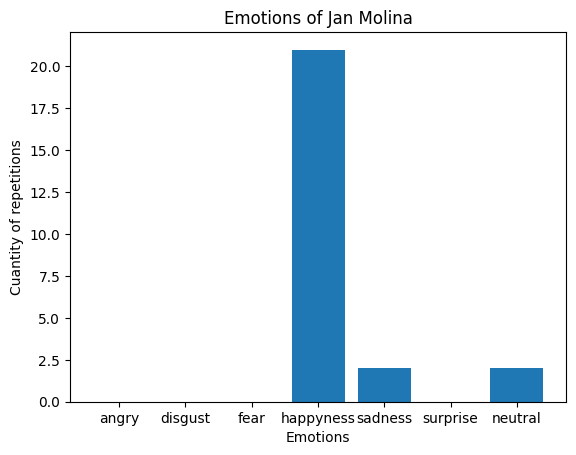

______________________________________________________________




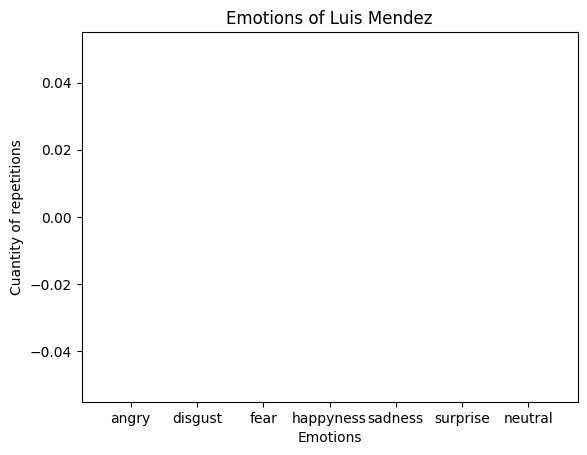

______________________________________________________________




In [ ]:
def consulta7():

  with open("Archivo_Entrevistado", "rb") as f:
      entrevistados = pickle.load(f)
  """
  This function will create a graph to compare all the emotions that
  each person had in the interview
  """

  # Each person is going to assign the variables of emotions at 0
  for person in entrevistados:
    emotions = []
    angry = 0
    disgust = 0
    fear = 0
    happyness = 0
    sadness = 0
    surprise = 0
    neutral = 0
    images = person.image
    image_info = images.get('Image_info')
    name = person.name

    # To each image, it will query the emotion and add it to a list
    for image in image_info:
      emotion = image[1]
      emotions.append(emotion)

    # If that emotion is found, 1 will be added to the variable of that emotion.
    for x in emotions:
      if x == "angry":
        angry += 1
      elif x == "disgust":
        disgust += 1
      elif x == "fear":
        fear += 1
      elif x == "happyness":
        happyness += 1
      elif x == "sadness":
        sadness += 1
      elif x == "surprise":
        surprise += 1
      elif x == "neutral":
        neutral += 1

    # It will create a graph with the data and with the help of the matplotlib.pyplot library    
    nombres = ['angry', 'disgust', 'fear', 'happyness', 'sadness', 'surprise', 'neutral']
    valores = [angry, disgust, fear, happyness, sadness, surprise, neutral]
    plt.bar(nombres, valores)
    plt.title("Emotions of "+ name)
    plt.xlabel('Emotions')
    plt.ylabel('Cuantity of repetitions')
    plt.show()
    print("______________________________________________________________")
    print()
    print()

consulta7()


## Consulta 10


In [ ]:
def consulta10():
  with open("Archivo_Entrevistado", "rb") as f:
    entrevistados = pickle.load(f)

  with open("Archivo_Evaluador", "rb") as m:
    evaluador = pickle.load(m)
    evaluadores = []
    for person in evaluador:
      name = person.name
      evaluadores.append(name)

    print("¿Quien es el evaluador?", evaluadores )
    nombre = str(input("Escribe a continuación tu nombre: "))
    while nombre not in evaluadores:
      print("Error,", nombre, "no está en la lista")
      print("¿Quien es el evaluador?", evaluadores )
      nombre = str(input("Escribe a continuación tu nombre: "))



    personas = []
    for entrevistado in entrevistados:
      print(f"\nEntrevistador: {entrevistado.entrevistador}")
      print(f"\nNombre: {entrevistado.name}")
      name = entrevistado.name
      personas.append(name)
      print(f"Identificacion: {entrevistado.ide}")
      print(f"Fecha de Nacimiento: {entrevistado.date_of_birth}")
      print(f"Lugar de Nacimiento: {entrevistado.nationality}")
      print(f"Numeros de Telefono: {entrevistado.phone_numbers}")
      print(f"Correos electronicos: {entrevistado.emails}")
      print(f"Direccion: {entrevistado.direction}")
      print(f"Estado civil: {entrevistado.civil_state}")
      print(f"Cantidad de hijos: {entrevistado.cont_child}")
      child = entrevistado.children
      images = entrevistado.image
      c2 = 0
      lista = child.get(f"hijo")

      if len(child) != 0:
        for niño in lista:
          gender = niño.get('genero')
          print("   Gender:", gender)
          birth = niño.get('nacimiento')
          print("   Date birth: ",birth)
          print("   -----------")

      
    
      info = images.get("Image_info")
      print("Image Info:")
      print()
      for f in info:
          print(" Image path:", f[0] )
          print(" Emotion:", f[1])
          print(" Ubication:", f[2])
          print("--------------------------------------------------------------------------")

    for person in personas:
      print("¿Deseas contratar a alguien?", personas )
      nombre = str(input("Escribe a continuación a quien vas a contratar: "))
      while nombre not in evaluadores:
        print("Error,", nombre, "no está en la lista")
        print("¿Deseas contratar a alguien?", personas )
        nombre = str(input("Escribe a continuación a quien vas a contratar: "))

      
consulta10()

# <font color='red'>Configuraciones Administrativas:</font>

## <font color='Red'>||</font> Borrar Archivos: <font color='Red'>||</font>
Estos tres bloques de codigo permite, borrar los archivos y agregar archivos en blanco para empeazar una nueva entrevista

In [ ]:
#@title Archivo Entrevistador
#Crear archivo vacio
borrar = input("¿Desea borrar todos los datos de los Entrevistadores? \nATENCION!! NO HAY VUELTA ATRAS, ¿Deseas eliminarlos? (y, n) ")
if borrar == "y":
  with open("Archivo_Entrevistador", "wb") as f:
    pass
  archivo_vacio = True
  
  print("¡Archivo borrado completamente!")

In [ ]:
#@title Archivo Evaluador
#Crear archivo vacio
borrar = input("¿Desea borrar todos los datos de los Evaluadores? \nATENCION!! NO HAY VUELTA ATRAS, ¿Deseas eliminarlos? (y, n) ")
if borrar == "y":
  with open("Archivo_Evaluador", "wb") as f:
    pass
  archivo_vacio = True
  
  print("¡Archivo borrado completamente!")

¿Desea borrar todos los datos de los Evaluadores? 
ATENCION!! NO HAY VUELTA ATRAS, ¿Deseas eliminarlos? (y, n) y
¡Archivo borrado completamente!


In [ ]:
#@title Archivo Entrevistado
##Crear archivo vacio
borrar = input("¿Desea borrar todos los datos de los Entrevistados? \nATENCION!! NO HAY VUELTA ATRAS, ¿Deseas eliminarlos? (y, n) ")
if borrar == "y":
  with open("Archivo_Entrevistado", "wb") as f:
    pass
  archivo_vacio = True
  
  print("¡Archivo borrado completamente!")

¿Desea borrar todos los datos de los Entrevistados? 
ATENCION!! NO HAY VUELTA ATRAS, ¿Deseas eliminarlos? (y, n) y
¡Archivo borrado completamente!


## <font color='green'>||</font> Guardar Archivos: <font color='green'>||</font>

Este bloque de codigo permite guardar los archivos editados que estan funcionando en el Notebook a drive para poderlos utilizar en otro momento


In [ ]:
# Archivo Entrevistador
archivo_drive = '/content/drive/MyDrive/Intro/Proyecto/Archivo_Entrevistador'
destino_colab = '/content/Archivo_Entrevistador'
shutil.copyfile(destino_colab, archivo_drive)

# Archivo Evaluador
archivo_drive = '/content/drive/MyDrive/Intro/Proyecto/Archivo_Evaluador'
destino_colab = '/content/Archivo_Evaluador'
shutil.copyfile(destino_colab, archivo_drive)

# Archivo Entrevistado
archivo_drive = '/content/drive/MyDrive/Intro/Proyecto/Archivo_Entrevistado'
destino_colab = '/content/Archivo_Entrevistado'
shutil.copyfile(destino_colab, archivo_drive)

'/content/drive/MyDrive/Intro/Proyecto/Archivo_Entrevistado'

# <font color='yellow'>Aspectos Administrativas:</font>


* La tarea será desarrollada en equipos de trabajo de máximo 2 personas.
* Cualquier acción de plagio será sancionada con una nota de 0 y la carta al expediente respectiva para todos los
implicados.
* La fecha de entrega será la semana 14, el día de clases, antes de la hora de clases.
* Para llevar el control de versiones del proyecto se debe crear un repositorio en GitLab y agregar al profesor (agregarlo
a la cuenta amendez.tec@gmail.com).
* Para llevar el control del las tareas a realizar por participante en el proyecto debe utilizar la herramienta
https://trello.com/es y compartir el link en el mismo Google Doc en que se comparte el link de la plantilla de Overleaf. Pueden crear tab de todas las tareas o requerimientos, un tab para las tareas en proceso y un tab para las tareas hechas.
* La codificación y documentación interna deberá ser desarrollada en idioma inglés utilizando el estándar docString de Python.
*La documentación externa debe estar redactada en idioma inglés utilizando la herramienta Overleaf (utilizar la plantilla facilitada por el profesor). La documentación es evaluada en el curso de Introducción a la programación.
* Documentación del Código utilizando Docstring Conventions 	
* Introducción a Python la Guía de Estilo de Código en Python
* La entrega será mediante la plataforma TecDigital en el espacio de Proyecto – Etapa 2. Lo que debe subir es un archivo de tipo notebook cuya extensión es (.ipynb). Además, en este archivo deben venir los enlaces a las imagenes utilizados para la tarea.
* Se recomienda que se empiece a trabajar lo antes posible.



# "La programación es una habilidad que puedes cultivar en ti mismo y usar para cambiar el mundo". - Barack Obama